In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from natsort import natsorted
from scipy import stats
from sklearn.cluster import KMeans

In [15]:
scrna_original = pd.read_csv(
    "../../HIPSD_seq/data/numbat_smoothed_expressions.tsv.gz", sep="\t", index_col=0
)

In [16]:
cna = pd.read_csv("../../HIPSD_seq/data/CNVs_HIPSDR_metacells_100kb.csv.gz", index_col=0)

In [17]:
def cluster_data(df):
    kmeans = KMeans(n_clusters=2, random_state=42)  # Number of clusters
    kmeans.fit(df)
    labels = kmeans.labels_
    df1 = pd.DataFrame(index=df.index)
    df1["cluster"] = labels
    df1_cluster1 = df1[df1["cluster"] == 1].index
    df1_cluster0 = df1[df1["cluster"] == 0].index

    return df1_cluster1, df1_cluster0

In [18]:
rna_cl1, rna_cl0 = cluster_data(scrna_original)
dna_cl1, dna_cl0 = cluster_data(cna)

In [19]:
def prepare_bulk_for_dna(path):
    bulk = pd.read_csv(path, sep="\t", header=None)
    bulk.columns = ["chrom_num", "start", "end", "CN", "median"]
    bulk.chrom_num = [x[3:] for x in bulk.chrom_num]

    bulk["chrom"] = "chr" + bulk.chrom_num
    bulk.chrom_num = bulk.chrom_num.replace({"X": 23, "Y": 24})
    bulk.chrom_num = bulk.chrom_num.astype(int)
    bulk = bulk.sort_values(by=["chrom_num", "start"])
    bulk["CN"] = bulk["CN"] - 1
    bulk["CN"] = bulk["CN"].replace(0, 1)

    bulk["window"] = [f"{tup.chrom}:{tup.start}-{tup.end}" for tup in bulk.itertuples()]
    bulk = bulk.loc[bulk["chrom"] != "chrY"]
    bulk.set_index("window", inplace=True)
    return bulk

In [20]:
def prepare_bulk_for_rna(path):
    bulk = pd.read_csv(path, index_col=0)
    bulk.columns = ["bin", "chrom", "start", "end", "CN", "median"]
    bulk["chrom_num"] = [x[3:] for x in bulk.chrom]
    bulk["CN"] = bulk["CN"] - 1
    bulk["CN"] = bulk["CN"].replace(0, 1)
    return bulk

In [21]:
def dist_func(x, y):
    return stats.pearsonr(x, y)[0]

In [22]:
bins = {}
for i in [10, 50, 100, 500, 1000]:
    print(f"Working on bin size {i}")
    rna = pd.read_csv(f"../../HIPSD_seq/data/numbat_rna_windows_{i}.csv.gz", index_col=0)
    bins[i] = rna

Working on bin size 10
Working on bin size 50
Working on bin size 100
Working on bin size 500
Working on bin size 1000


### Maximum number of bins

In [23]:
dna = []
rna = []
for b in bins:
    print(f"Working on {b}")
    dna_sc = pd.read_csv(f"../../HIPSD_seq/data/CNVs_HIPSDR_metacells_{b}kb.csv.gz", index_col=0)
    dna_sc = dna_sc[
        [col for col in natsorted(dna_sc.columns) if not col.startswith("chrY")]
    ].copy()
    dna_sc = dna_sc.loc[dna_cl0]
    rna_sc = bins[b]
    rna_sc = rna_sc[natsorted(rna_sc.columns)].copy()
    rna_sc = rna_sc.loc[rna_cl0]
    print(dna_sc.shape)
    print(rna_sc.shape)

    bulk = prepare_bulk_for_dna(
        f"../../HIPSD_seq/data/readcounts.{b}kb.cell_bc_p195_per_bin_calls_long.bed"
    )
    bulk_dna = bulk.loc[dna_sc.columns]
    bulk_rna = bulk.loc[rna_sc.columns]
    print(bulk_dna.shape)
    print(bulk_rna.shape)

    dna.append(dna_sc.T.corrwith(bulk_dna.CN, axis=0).values)
    rna.append(rna_sc.T.corrwith(bulk_rna.CN, axis=0).values)

Working on 10
(195, 303114)
(2550, 99906)
(303114, 6)
(99906, 6)
Working on 50
(195, 60630)
(2550, 22748)
(60630, 6)
(22748, 6)
Working on 100
(195, 30321)
(2550, 12837)
(30321, 6)
(12837, 6)
Working on 500
(195, 6073)
(2550, 3861)
(6073, 6)
(3861, 6)
Working on 1000
(195, 3044)
(2550, 2262)
(3044, 6)
(2262, 6)


In [24]:
rna_df = pd.DataFrame(rna).T
rna_df.columns = [10, 50, 100, 500, 1000]

dna_df = pd.DataFrame(dna).T
dna_df.columns = [10, 50, 100, 500, 1000]

dna_df["type"] = "DNA"
rna_df["type"] = "RNA"

In [25]:
merged = pd.concat([dna_df, rna_df])
melted = merged.melt(value_vars=[10, 50, 100, 500, 1000], id_vars=["type"])

In [26]:
melted["variable"] = melted["variable"].astype(str)
melted["variable"] = melted["variable"] + "kb"

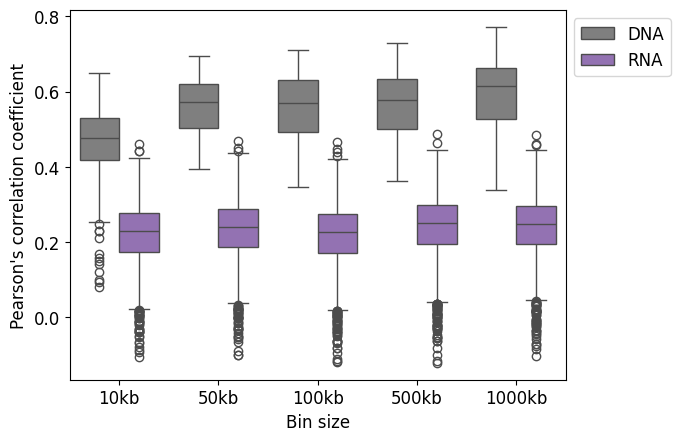

In [27]:
sns.boxplot(
    melted,
    x="variable",
    y="value",
    hue="type",
    palette=[sns.color_palette("tab10")[7], sns.color_palette("tab10")[4]],
)

plt.xlabel("Bin size", fontsize=12)
plt.ylabel("Pearson's correlation coefficient", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)

plt.savefig("figure2/resolution_corr_binsizes.png", dpi=300)
plt.savefig("figure2/resolution_corr_binsizes.svg", dpi=300)

### Overlapping bins

In [28]:
dna = []
rna = []
for b in bins:
    print(f"Working on {b}")
    dna_sc = pd.read_csv(f"../../HIPSD_seq/data/CNVs_HIPSDR_metacells_{b}kb.csv.gz", index_col=0)
    dna_sc = dna_sc[
        [col for col in natsorted(dna_sc.columns) if not col.startswith("chrY")]
    ].copy()
    dna_sc = dna_sc.loc[dna_cl0]
    rna_sc = bins[b]
    rna_sc = rna_sc[natsorted(rna_sc.columns)].copy()
    rna_sc = rna_sc.loc[rna_cl0]

    bulk = prepare_bulk_for_dna(
        f"../../HIPSD_seq/data/readcounts.{b}kb.cell_bc_p195_per_bin_calls_long.bed"
    )
    bulk_dna = bulk.loc[dna_sc.columns]
    bulk_rna = bulk.loc[rna_sc.columns]
    dna_sc = dna_sc[rna_sc.columns]
    print(bulk_dna.shape)
    print(bulk_rna.shape)
    print(dna_sc.shape)
    print(rna_sc.shape)

    dna.append(dna_sc.T.corrwith(bulk_rna.CN, axis=0).values)
    rna.append(rna_sc.T.corrwith(bulk_rna.CN, axis=0).values)

Working on 10
(303114, 6)
(99906, 6)
(195, 99906)
(2550, 99906)
Working on 50
(60630, 6)
(22748, 6)
(195, 22748)
(2550, 22748)
Working on 100
(30321, 6)
(12837, 6)
(195, 12837)
(2550, 12837)
Working on 500
(6073, 6)
(3861, 6)
(195, 3861)
(2550, 3861)
Working on 1000
(3044, 6)
(2262, 6)
(195, 2262)
(2550, 2262)


In [29]:
rna_df = pd.DataFrame(rna).T
rna_df.columns = [10, 50, 100, 500, 1000]

dna_df = pd.DataFrame(dna).T
dna_df.columns = [10, 50, 100, 500, 1000]

dna_df["type"] = "DNA"
rna_df["type"] = "RNA"

In [30]:
merged = pd.concat([dna_df, rna_df])
melted = merged.melt(value_vars=[10, 50, 100, 500, 1000], id_vars=["type"])

In [31]:
melted["variable"] = melted["variable"].astype(str)
melted["variable"] = melted["variable"] + "kb"

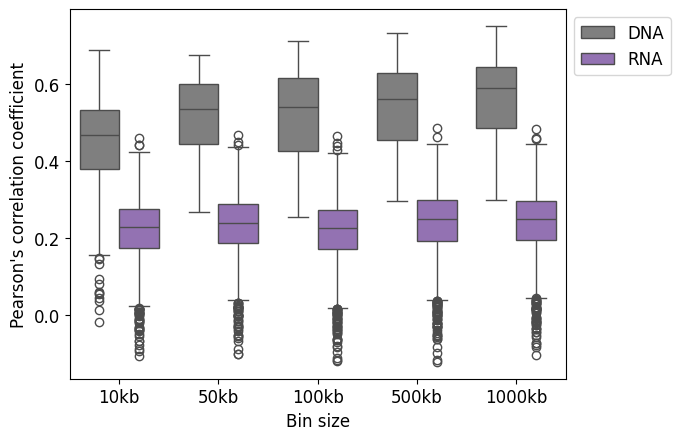

In [32]:
sns.boxplot(
    melted,
    x="variable",
    y="value",
    hue="type",
    palette=[sns.color_palette("tab10")[7], sns.color_palette("tab10")[4]],
)

plt.xlabel("Bin size", fontsize=12)
plt.ylabel("Pearson's correlation coefficient", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)

plt.savefig("figure2/resolution_corr_binsizes_supp.png", dpi=300)
plt.savefig("figure2/resolution_corr_binsizes_supp.svg", dpi=300)

## F1 score

In [33]:
df1 = pd.read_csv("../data/merged_bin_100kb.csv", index_col=0)
df2 = pd.read_csv("../data/merged_bin_500kb.csv", index_col=0)
df3 = pd.read_csv("../data/merged_bin_1000kb.csv", index_col=0)

/var/folders/zr/5fr8vc4j0ld_zppj3b771d700000gr/T/ipykernel_24853/1798424954.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels=["500kb", "1MB", "5MB", "10MB"], fontsize=16)
/var/folders/zr/5fr8vc4j0ld_zppj3b771d700000gr/T/ipykernel_24853/1798424954.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels=["2.5MB", "5MB", "25MB", "50MB"], fontsize=16)
/var/folders/zr/5fr8vc4j0ld_zppj3b771d700000gr/T/ipykernel_24853/1798424954.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(labels=["5MB", "10MB", "50MB", "100MB"], fontsize=16)


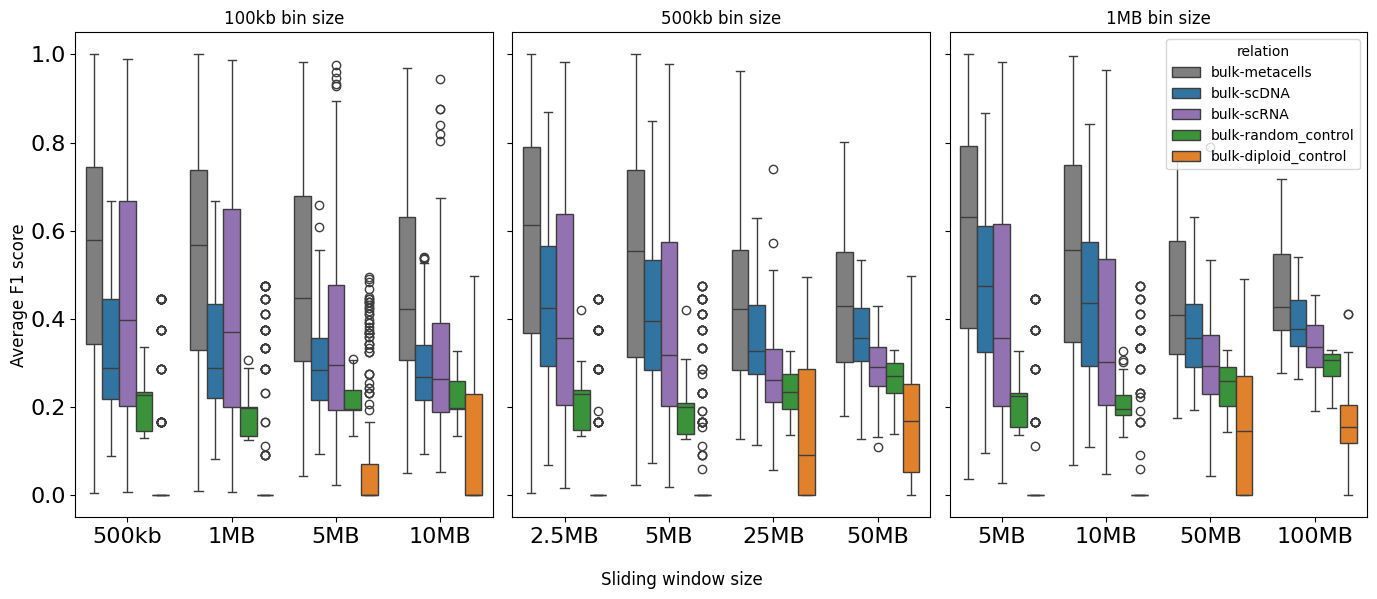

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
f1 = sns.boxplot(
    df1,
    y="f1_score",
    x="window_size",
    hue="relation",
    ax=axes[0],
    legend=False,
    order=[5, 10, 50, 100],
    palette={
        "bulk-metacells": sns.color_palette("tab10")[7],
        "bulk-scRNA": sns.color_palette("tab10")[4],
        "bulk-scDNA": sns.palettes.color_palette("tab10")[0],
        "bulk-random_control": sns.palettes.color_palette("tab10")[2],
        "bulk-diploid_control": sns.palettes.color_palette("tab10")[1],
    },
)
axes[0].tick_params(axis="y", labelsize=16)
axes[0].set_xticklabels(labels=["500kb", "1MB", "5MB", "10MB"], fontsize=16)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].set_title("100kb bin size")
f2 = sns.boxplot(
    df2,
    y="f1_score",
    x="window_size",
    hue="relation",
    ax=axes[1],
    legend=False,
    order=[5, 10, 50, 100],
    palette={
        "bulk-metacells": sns.color_palette("tab10")[7],
        "bulk-scRNA": sns.color_palette("tab10")[4],
        "bulk-scDNA": sns.palettes.color_palette("tab10")[0],
        "bulk-random_control": sns.palettes.color_palette("tab10")[2],
        "bulk-diploid_control": sns.palettes.color_palette("tab10")[1],
    },
)
axes[1].set_xticklabels(labels=["2.5MB", "5MB", "25MB", "50MB"], fontsize=16)
axes[1].set_title("500kb bin size")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
f3 = sns.boxplot(
    df3,
    y="f1_score",
    x="window_size",
    hue="relation",
    ax=axes[2],
    legend=True,
    order=[5, 10, 50, 100],
    palette={
        "bulk-metacells": sns.color_palette("tab10")[7],
        "bulk-scRNA": sns.color_palette("tab10")[4],
        "bulk-scDNA": sns.palettes.color_palette("tab10")[0],
        "bulk-random_control": sns.palettes.color_palette("tab10")[2],
        "bulk-diploid_control": sns.palettes.color_palette("tab10")[1],
    },
)
axes[2].set_xticklabels(labels=["5MB", "10MB", "50MB", "100MB"], fontsize=16)
axes[2].set_title("1MB bin size")
axes[2].set_xlabel("")
axes[2].set_ylabel("")
plt.yticks(fontsize=16)

fig.supxlabel("Sliding window size")
fig.supylabel("Average F1 score")
plt.tight_layout()
plt.savefig("resolution.png", dpi=300)
plt.savefig("resolution.svg", dpi=300)